## Latent visualization space
Script for visualizing latent space for the RNNVAE. Visualization of selected dimensions, over time, testing visualization, colors, the like.

WARNING: messy Script

In [30]:
#Import
# working dir
%cd /homedtic/gmarti/CODE/RNN-VAE/

# Imports
import sys
sys.path.insert(0, '/homedtic/gmarti/CODE/RNN-VAE/')
from rnnvae.utils import open_MRI_data_var, open_MRI_data
from rnnvae import rnnvae
from rnnvae.plot import plot_losses, plot_trajectory, plot_total_loss, plot_z_2d, plot_z_time_2d
import os
import math
from rnnvae.data_gen import SinDataGenerator
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import torch

%matplotlib inline

/homedtic/gmarti/CODE/RNN-VAE


In [31]:
# DEVICE
## Decidint on device on device.
DEVICE_ID = 0
DEVICE = torch.device('cuda:' + str(DEVICE_ID) if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.cuda.set_device(DEVICE_ID)

out_dir = "experiments/meta_mri_nolin/_h_10_z_3_hid_10_ntp_4_n_300_l_1/"

#load parameters
#p = eval(open(out_dir + "params.txt").read())
#print(p['curves'])

p = {
    "x_size": 40,
    "h_size": 10,
    "z_dim": 3,
    "hidden": 10,
    "n_layers": 1,
    "n_epochs": 1500,
    "clip": 10,
    "learning_rate": 1e-3,
    "ntp": 4,
    "batch_size": 128,
    "seed": 1714,
}


model = rnnvae.ModelRNNVAE(p["x_size"], p["h_size"], p["hidden"], p["n_layers"], 
                        p["hidden"], p["n_layers"], p["hidden"],
                        p["n_layers"], p["z_dim"], p["hidden"], p["n_layers"],
                        p["clip"], p["n_epochs"], p["batch_size"], DEVICE)
model.load(out_dir+'model.pt')
model = model.to(DEVICE)

In [32]:
# LOAD DATA
#TODO: here we should load, someway, the labels corresponding to the subjects
# add a flag to the function to return them or something
#I would like to get, at least, age and dx
csv_path = "data/tadpole_mrionly.csv"
padding=False
if padding:

    X_train, X_test, Y_train, Y_test = open_MRI_data_var(csv_path, train_set=0.9, normalize=True, return_covariates=True)

    nfeatures = X_train[0].shape[1]

    # Apply padding to both X_train and X_val
    X_train_tensor = [ torch.FloatTensor(t) for t in X_train ]
    X_train_pad = nn.utils.rnn.pad_sequence(X_train_tensor, batch_first=False, padding_value=np.nan)
    X_test_tensor = [ torch.FloatTensor(t) for t in X_test ]
    X_test_pad = nn.utils.rnn.pad_sequence(X_test_tensor, batch_first=False, padding_value=np.nan)

    # Those datasets are of size [Tmax, Batch_size, nfeatures]
    mask_train = ~torch.isnan(X_train_pad)
    mask_test = ~torch.isnan(X_test_pad)

    #convert those NaN to zeros
    X_train_pad[torch.isnan(X_train_pad)] = 0
    X_test_pad[torch.isnan(X_test_pad)] = 0

    max_timepoints = X_train_pad.shape[0]
    # Those datasets are of size [Tmax, Batch_size, nfeatures]
    # Predict the reconstructions from X_val and X_train
    X_test_fwd = model.predict(X_test_pad.to(DEVICE))
    X_train_fwd = model.predict(X_train_pad.to(DEVICE))

else:
    X_train, X_test, Y_train, Y_test = open_MRI_data(csv_path, train_set=0.8, n_followups=p["ntp"], normalize=True, return_covariates=True)

    # List of (nt, nfeatures) numpy objects
    p["x_size"] = X_train[0].shape[1]
    print(p["x_size"])

    # Apply padding to both X_train and X_val
    #Permute so that dimension is (tp, nbatch, feat)
    X_train_tensor = torch.FloatTensor(X_train).permute((1,0,2))
    X_test_tensor = torch.FloatTensor(X_test).permute((1,0,2))
    
    X_test_fwd = model.predict(X_test_tensor.to(DEVICE))
    X_train_fwd = model.predict(X_train_tensor.to(DEVICE))




(2488, 50)
40


In [33]:
#Reshape features so that nsubjects go first
X_train_hat = np.array(X_train_fwd['xnext']).swapaxes(0,1)
z_train = np.array(X_train_fwd['z']).swapaxes(0,1)
X_test_hat = np.array(X_test_fwd['xnext']).swapaxes(0,1)
z_test = np.array(X_test_fwd['z']).swapaxes(0,1)


Now start testing on the actual latent space. I want to program three main ways of latent space visualization:

1. Classic latent space visualization: selecting a specific time point and two specific latent dimensions, plot a 2D projection. Color by diagnosis? or by what?

2. Trajectory: for a specific latent dimension z_t, plot a 2d line over all timepoints. Plot all the subjects as lines, then try to visualize a general trajectory for that dimension? Maybe make the function flexible enough to 

3. Trajectory on 2D space: for two specific dimensions, plot a 2d space with all the timepoints z, and color the z by timepoints. See if there is a structure in the time over the selected dimensions of the latent space.

In [34]:
#First get the latent space
#Note that we have to apply the mask all the same!

if padding:
    #Hack: instead of nfeatures, we have a latent space, with a different dimensionality. But we want to capture it anyway, so 
    #just select a number of dimensions equals to z_dim (should be all true!)
    z_train = [Z[mask_train[:,i,:z_dim]].reshape((-1, z_dim)) for (i, Z) in enumerate(z_train)]
    z_test = [Z[mask_test[:,i,:z_dim]].reshape((-1, z_dim)) for (i, Z) in enumerate(z_test)]

In [35]:
##1 Classic latent space visualization
dim0 = 0
dim1 = 2
z_t = 3
color = 'AGE_demog'

#prepare the data
train_z_d0 = np.array([x[z_t, dim0] for x in z_train if x.shape[0] > z_t])
train_z_d1 = np.array([x[z_t, dim1] for x in z_train if x.shape[0] > z_t])
print(z_train.shape)
test_z_d0 = np.array([x[z_t, dim0] for x in z_test if x.shape[0] > z_t ])
test_z_d1 = np.array([x[z_t, dim1] for x in z_test if x.shape[0] > z_t])

z_d0 = np.append(train_z_d0 , test_z_d0)
z_d1 = np.append(train_z_d1, test_z_d1)

#Select colors
train_color = np.array([x[z_t] for x in Y_train[color] if x.shape[0] > z_t])
test_color = np.array([x[z_t] for x in Y_test[color] if x.shape[0] > z_t])

color = np.append(train_color, test_color)

#run figure
print(len(z_d0))
print(len(z_d1))
print(len(color))
plot_z_2d(z_d0, z_d1, z_t, color, [dim0, dim1], out_dir)

(497, 4, 3)
622
622
622


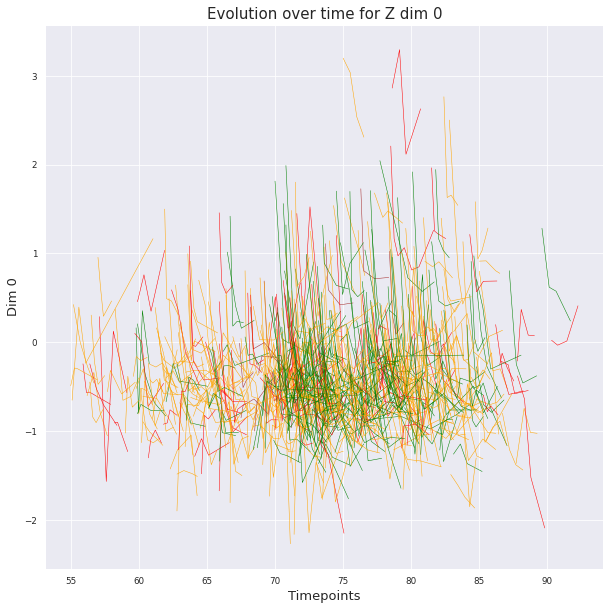

In [36]:
# 2 Trajectory latent space visualization
###THIS TRAJECTORY WILL NOT BE USED WIDELY SO LETS DONT PUT INTO A FUNCTION (ALSO IM LAZY)
dim = 4
color = 'DX_bl'
#TODO: THIS NEEDS TO BE SEPARATED BY SELECTED GROUPS
#COLOR SEMILINES BY DX AND THE MEAN LINES ALSO BY DX

#prepare the data
train_z_d0 = [x[:, dim0] for x in z_train]
test_z_d0 = [x[:, dim0] for x in z_test]
z_d0 = train_z_d0 + test_z_d0

#prepare DX labels
labels_train = [x[0] for x in Y_train[color]]
labels_test = [x[0] for x in Y_test[color]]
labels = labels_train + labels_test

# Prepare AGE for plotting
age_train = [x for x in Y_train["AGE"]]
age_test = [x for x in Y_test["AGE"]]
age = age_train + age_test

# TODO: WHY DO SOME AGE VALUES GO BACKWARDS IN TIME? AM I SURE THAT THERE HAS BEEN NO REORDERING?

dict_dx = {
    "AD": "red",
    "CN": "green",
    "SMC": "brown",
    "EMCI": "orange",
    "LMCI": "orange"
}

#plot all lines
#regarding the x axis: maybe it make sense to not use timepoints but...
#age?
# time from baseline?
#age probably is best
# TODO ADD AGE

plt.figure(figsize=(10,10))
for (line, dx, a) in zip(z_d0, labels, age):
    plt.plot(a, line, linewidth=0.5,c=dict_dx[dx])

#compute an approximation for each of the dx groups
#interpolate for the cases where we do not have enough points
#from https://stackoverflow.com/questions/51933785/getting-a-mean-curve-of-several-curves-with-x-values-not-being-the-same?noredirect=1&lq=1
if padding:
    for dx in set(labels):
        mean_x_axis = list(range(max_timepoints))
        mean_x_axis = np.linspace(50,90,100)
        ys_interp = [np.interp(mean_x_axis, a, x) for (x, d, a) in zip(z_d0, labels, age) if d==dx]
        mean_y_axis = np.mean(ys_interp, axis=0)

        #plot it too
        #This needs to be plotted differently from the others
        plt.plot(mean_x_axis, mean_y_axis,color=dict_dx[dx], linewidth=3)
    
plt.xlabel(f"Timepoints", size=13)
plt.ylabel(f"Dim {dim0}", size=13)
plt.title(f"Evolution over time for Z dim {dim0}", size=15)
plt.show()

2488
2488
2488


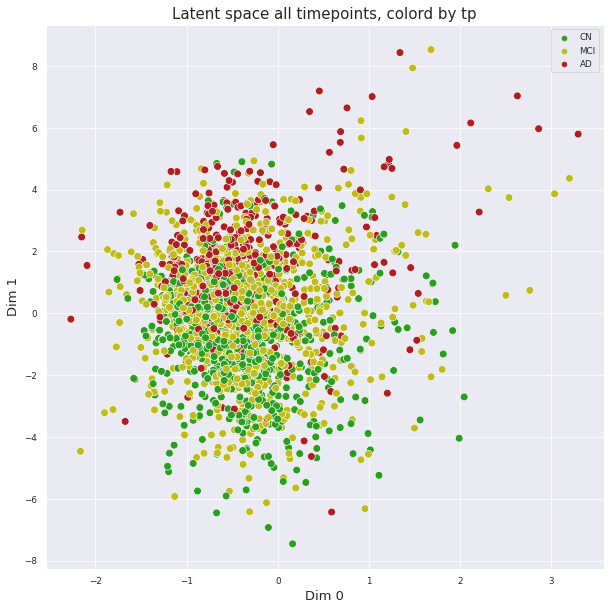

In [58]:
#3 2D Trajectory latent space visualization
dim0=0
dim1=1

#This needs to be colored by DX and AGE, and 

#plot_z_time_2d(z, max_timepoints, [dim0, dim1], out_dir, out_name='latent_space_2d')
plt.figure(figsize=(10, 10))

# create color cmap
colors = sns.color_palette("viridis", as_cmap=True)

#Pallete for dx
colors = sns.color_palette(["#2a9e1e", "#bfbc1a", "#af1f1f"])
# sns.set_palette(colors)

z_d0_full = []
z_d1_full = []
tp_full = []
color = []

# Create dictionary of the different labels
dx_dict = {
    "NL": "CN",
    "MCI": "MCI",
    "MCI to NL": "CN",
    "Dementia": "AD",
    "Dementia to MCI": "MCI",
    "NL to MCI": "MCI",
    "MCI to Dementia": "AD",
}

for tp in range(p["ntp"]):
    train_z_d0 = [x[tp, dim0] for x in z_train if x.shape[0] > tp]
    test_z_d0 = [x[tp, dim0] for x in z_test if x.shape[0] > tp]

    train_z_d1 = [x[tp, dim1] for x in z_train if x.shape[0] > tp]
    test_z_d1 = [x[tp, dim1] for x in z_test if x.shape[0] > tp]
    
    z_d0_full = z_d0_full + train_z_d0
    z_d0_full = z_d0_full + test_z_d0

    z_d1_full = z_d1_full + train_z_d1
    z_d1_full = z_d1_full +test_z_d1
    
    tp_len = len(train_z_d0) + len(test_z_d0)
    tp_full = tp_full + [tp]*tp_len

    # Prepare AGE for plotting
    color_train = [dx_dict[x[tp]] for x in Y_train["DX"]]
    color_test = [dx_dict[x[tp]] for x in Y_test["DX"]]
    #color_train = [x[tp] for x in Y_train["AGE"]]
    #color_test = [x[tp] for x in Y_test["AGE"]]
    
    color = color + color_train + color_test
    
print(len(z_d0_full))
print(len(z_d1_full))
print(len(color))
sns.scatterplot(x=z_d0_full, y=z_d1_full, hue=color, palette=colors, s=60)


##Add title, x and y axis
plt.xlabel(f"Dim {dim0}", size=13)
plt.ylabel(f"Dim {dim1}", size=13)
plt.title(f"Latent space all timepoints, colord by tp", size=15)
plt.show()
